# Introduction

This file provides an analysis of Airbnb listings, reviews, and visits data. 

It starts by importing necessary libraries and loading datasets. The data is then assessed, cleaned, and preprocessed. The script explores prevalent words in listings' descriptions, satisfaction levels across different price cohorts, and how numerical variables affect prices and satisfaction. It also investigates how features, both numerical and categorical, affect the average price. The data is prepared by handling missing values, creating dummy variables, and splitting into train and test sets. A linear regression model is then trained and assessed. 

The script concludes by identifying underpriced areas and unnecessary amenities.

# Section 1: Business understanding

The main goal of this analysis is to answer some questions that will be instrumental in looking for a place to stay on vacation. These questions are:


- **What are the most prevalent words in listings' descriptions?**

- **Are satisfaction levels different between price cohorts?**

- **How features (numerical and categorical) affect the average price for the better or worse?**


But first, we need to start with loading and reviewing the data.

## Load required libraries and data

Start with importing required libraries and datasets

In [140]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud
from collections import Counter

# disable pandas warnings
pd.options.mode.chained_assignment = None

In [141]:
# Load datasets
visits = pd.read_csv('./dataset/calendar.csv')
reviews = pd.read_csv('./dataset/reviews.csv')
listings = pd.read_csv('./dataset/listings.csv')

# Section 2: Data Understanding

In this section, I will review the dataset and attempt at answering above-mentioned questions with simple statsitics.

The three available files are as follows.

In [142]:
# Check the calendar.csv file's contents
v_num = visits[~visits['price'].isna()].shape[0]
last = visits.sort_values(by='date', ascending=True)['date'].max()
first = visits.sort_values(by='date', ascending=True)['date'].min()
print(f'The calendar.csv file contains {v_num} visits with price points spanning {first} and {last}.')

# Check the reviews.csv file's contents
nb_comments = reviews[~reviews['comments'].isna()].shape[0]
print(f'The reviews.csv file contains {reviews.shape[0]} reviews with {nb_comments} comments.')

# Check the listings.csv file's contents
nb_unique_listings = listings['id'].nunique()
print(f'The listings.csv file contains {nb_unique_listings} unique listings.')

The calendar.csv file contains 643037 visits with price points spanning 2016-09-06 and 2017-09-05.
The reviews.csv file contains 68275 reviews with 68222 comments.
The listings.csv file contains 3585 unique listings.


In [143]:
print(f'The calendar.csv file contains {visits.select_dtypes("object").shape[1]} categorical variables and {visits.select_dtypes(["float64", "int"]).shape[1]} numerical variables.')
print(f'The reviews.csv file contains {reviews.select_dtypes("object").shape[1]} categorical variables and {reviews.select_dtypes(["float64", "int"]).shape[1]} numerical variables.')
print(f'The listings.csv file contains {listings.select_dtypes("object").shape[1]} categorical variables and {listings.select_dtypes(["float64", "int"]).shape[1]} numerical variables.')

The calendar.csv file contains 3 categorical variables and 1 numerical variables.
The reviews.csv file contains 3 categorical variables and 3 numerical variables.
The listings.csv file contains 62 categorical variables and 33 numerical variables.


### Start cleaning first data points  

A brief overview of the dataset shows that the price is stored as an object due to comma separators and $ signs. We need to change that to numerical values as well as standardize listing unique ids to start the analysis.

In [144]:
# Clean and preprocess data
visits['price'] = visits['price'].str.strip('$').str.replace(',','').astype(float)   # convert $ amounts to float
listings.rename(columns={'id': 'listing_id'}, inplace=True)                          # rename the key to easily join files

### What are the most prevalent words in listings' descriptions?

To get a better understanding of what may be the leading listings characteristings, we need to count unique words in their descriptions

In [145]:
# Count words in listings' descriptions
word_count = Counter()
listings['description'].str.lower().str.split().apply(word_count.update)

# Remove non-informative words to decrease clutter
fluff_words = ['the', 'and', 'at', 'an', 'it\'s', 'or', 'great', 'your', 'all.', 'just', 'as', 'that', 'there', 'we', 
               'have',  'a', 'also', 'to', 'in', 'my', 'is', 'it', 'if', 'of', 'with', 'our', 'has', 'for', 'you', 'be', 
               'on', 'this', 'from', '&', 'i', '-', 'very', 'can', 'will', '2', 'boston', 'are', 'walk']

for fluff in fluff_words:
    if fluff in word_count:
        del word_count[fluff]

In [146]:
word_count.most_common(20)

[('apartment', 2674),
 ('room', 2455),
 ('living', 1845),
 ('bedroom', 1822),
 ('all', 1816),
 ('located', 1750),
 ('private', 1647),
 ('one', 1634),
 ('access', 1593),
 ('kitchen', 1488),
 ('full', 1377),
 ('two', 1350),
 ('place', 1247),
 ('close', 1182),
 ('floor', 1172),
 ('bed', 1137),
 ('back', 1130),
 ('street', 1130),
 ('downtown', 1129),
 ('queen', 1063)]

It appears the most common words are related to location or additional facilities but let's plot the counter to visually identify them 

(-0.5, 999.5, 499.5, -0.5)

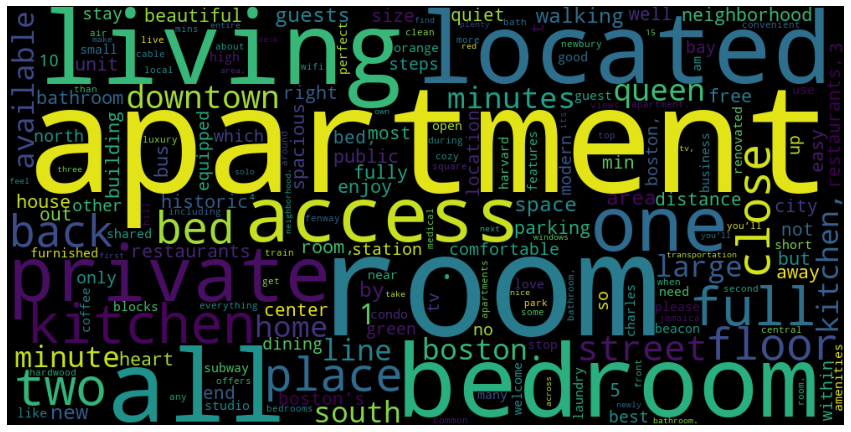

In [147]:
# Plot a word cloud for the most common words
word_count = dict(word_count)
wordcloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(word_count)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")

Two types of location-related words frequently appear in descriptions: 
- **relative proximity** (close, minutes, walking, distance, etc.)
- **location** (located, south, north, street, downtown, etc.)

These dominate the overall message; however, other aspects related to amenities can be found (as queen, large, bed, tv, etc.).

### Are satisfaction levels different between price cohorts?

Before continuing the analysis, it's worth checking if the price already discounts any other factors that may impact customer satisfaction. To that end, we will calculate an average price and divide all listings into four price quartiles to compare relative satisfaction among them.

In [148]:
# Add average price per listing based on actual bookings recorded in the dataset rather than declared price
avg_prices = visits.dropna(subset=['price'], how='any', axis=0).groupby(by='listing_id').agg(avg_price=('price','mean'))
listings_w_prices = listings.join(avg_prices, on='listing_id', how='left')
listings_w_prices = listings_w_prices.dropna(axis=1, how='all')

# Label listings with average price quartile
listings_w_prices = listings_w_prices.dropna(subset=['avg_price'], how='any', axis=0)
listings_w_prices['price_quartile'] = pd.qcut(listings_w_prices['avg_price'], q=4, labels=['low', 'low_med', 'high_med', 'high'])

<AxesSubplot:title={'center':'review_scores_rating'}, xlabel='price_quartile'>

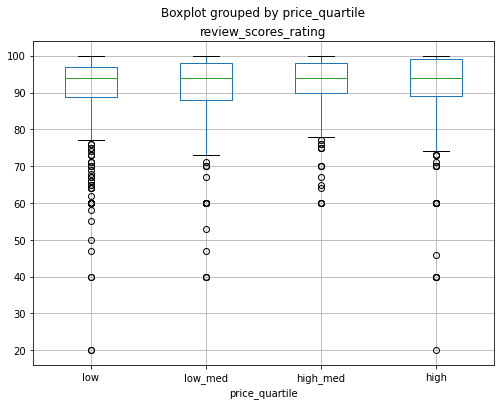

In [149]:
# Plot satisfaction across price quartiles
fig, ax = plt.subplots(figsize=(8,6))
listings_w_prices.boxplot(column=['review_scores_rating'], by='price_quartile', ax=ax)

Ratings across all price quartiles overlap and are mostly positive showing a clear bias. This suggests that price does not discount relative satisfaction. 

<AxesSubplot:>

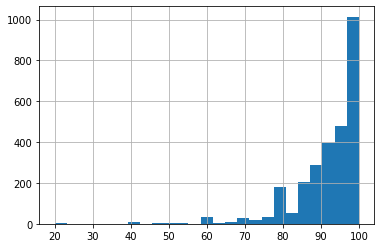

In [150]:
# Plot ratings distribution
listings['review_scores_rating'].hist(bins=25)

The distribution of ratings is clearly skewed towards higher ratings, which can hint at a survivorship bias (bad businesses bankrupt and disappear from the market quickly).

### How numerical variables affect prices and satisfaction?

Review ratings or number of rooms or bathrooms can define the price. Ultimately, the bigger the real estate, the more expensive it is. This; however, may result in tautologies (i.e. higher product quantity - size - or better review score - demand - increases the price). To study this problem, we will plot a correlation heatmap for numerical variables.

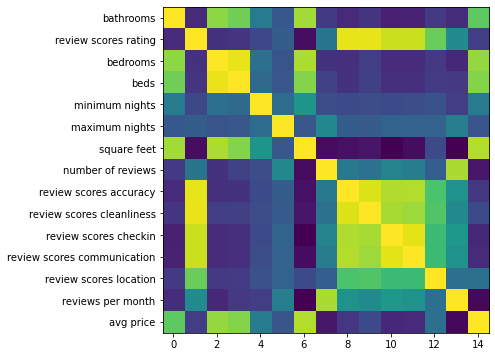

In [151]:
# Analyze correlation between features and price
num_features = ['bathrooms', 'review_scores_rating', 'bedrooms', 'beds', 'minimum_nights', 'maximum_nights','square_feet', 'number_of_reviews', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'reviews_per_month', 'avg_price']
listings_num_df = listings_w_prices[num_features]
listings_w_prices_corr = listings_num_df.corr()

# Plot correlation matrix
fig, ax = plt.subplots(figsize=(8,6))
plt.yticks([x for x in range(len(listings_w_prices_corr.columns))], [x.replace('_', ' ') for x in listings_w_prices_corr.columns])
plt.imshow(listings_w_prices_corr.select_dtypes(['float', 'int']).corr())

Average price seems to be mostly correlated with the number of reviews per month as well as ratings, which is reasonable since more popular places get more visitors. Let's dive into the biggest contributors into two factors we are interested in - average price and relative satisfaction.

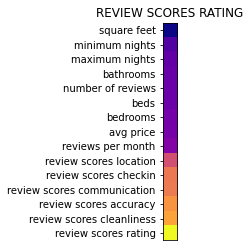

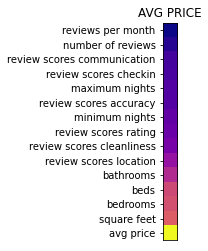

In [152]:
# Get relevant numerical features
num_features = ['bathrooms', 'review_scores_rating', 'bedrooms', 'beds', 'minimum_nights', 'maximum_nights','square_feet', 'number_of_reviews', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'reviews_per_month', 'avg_price']

# Check the correlaction with price and score ratings
listings_num_df = listings_w_prices[num_features]
listings_w_prices_corr = listings_num_df.corr()

for stat in ['review_scores_rating', 'avg_price']:
    listings_w_prices_corr = listings_w_prices_corr.sort_values(by=stat)
    plt.yticks([x for x in range(len(listings_w_prices_corr.index))], [x.replace('_', ' ') for x in listings_w_prices_corr.index])
    plt.xticks([])
    plt.title(stat.replace('_', ' ').upper())
    plt.imshow(listings_w_prices_corr[[stat]], cmap='plasma')
    plt.show()

The correlation map above shows that location score has the least correlation with overall satisfaction. Even a more distant place can be satisfactory if it’s clean, as cleanliness is the leading contributor to end rating. As expected, the size of the place (number of bedrooms, square feet, number of beds) increases the price while the location rating has the most impact on the price out of all partial ratings.

# Section 3: Data Preparation


## How features (numerical and categorical) affect the average price?

We know now approximately which features may be interesting to examine to manipulate our price while not surrendering the quality of stay. To measure their relative impact, let's create a linear model and review the coefficients of individual features. But first, we need to prepare the data.

**Categorical features will be transformed** in the following fashion:
- one-hot encoding to be processed for nominal features
- a feature containing list of available amenities to be transformed into a list of unique values before performing one-hot encoding
- missing values to be replaced with 0s in a separate column denoting a lack of given option since lack of information can impact user behaviour

In [153]:
# Get relevant categorical features
cat_features = ['cancellation_policy', 'require_guest_profile_picture', 'require_guest_phone_verification', 'host_is_superhost', 'host_response_time', 'neighbourhood_cleansed', 'host_identity_verified', 'property_type', 'room_type', 'bed_type', 'amenities']
listings_cat_df = listings_w_prices[cat_features]

# Preprocess amenities feature from lists strings (curly braces and quatation marks are unnecessary and to be removed)
listings_cat_df['amenities'] = listings_cat_df['amenities'].str.replace('{', '', regex=True).str.replace('}', '', regex=True).str.replace('"', '', regex=True).str.lower()
listings_cat_df['amenities'].fillna('x', inplace=True)   # put a placeholder in lieu of empty values

Define and apply function to split clean lists stored in cells into boolean dummy features proper for training.

In [154]:
def split_list_into_dummies(df, columns, n=20, delimiter=','):
    """
    This function splits a list of values from strings in each target column into dummy variables.
        E.g. a DataFrame {'col1': ['s,g,f', 's']} will return {'s': {0: 1, 1: 1}, ' g': {0: 1, 1: 0}, ' f': {0: 1, 1: 0}}
    
    Input:
        df (DataFrame): a dataframe to be transformed
        columns (list): a list with column names to be split into values
        n (int, optional): a number of the most common values to be included
        delimiter (str, optional): a delimiter to split the list into values
        
    Output:
        a dataframe with the target column removed and new columns holding top n unique values
        
    """

    # Get 20 most prevalent values in the string list
    for col in columns:
        list_elements = Counter()
        df[col].str.lower().str.split(delimiter).apply(list_elements.update)
        list_elements = [x for x in dict(list_elements.most_common(n)).keys()]
        
        # Create dummy variables for amenities
        for element in list_elements:
            df[element] = df[col].apply(lambda x: 1 if x.find(element) != -1 else 0)
        
        # Drop the column
        df.drop(columns=[col], inplace=True)
        print(f'The top {n} most common elements are:')
        print(list_elements)

        return df

In [155]:
listings_cat_df = split_list_into_dummies(listings_cat_df, ['amenities'])

The top 20 most common elements are:
['wireless internet', 'heating', 'kitchen', 'essentials', 'air conditioning', 'smoke detector', 'tv', 'internet', 'shampoo', 'carbon monoxide detector', 'washer', 'dryer', 'hangers', 'family/kid friendly', 'iron', 'hair dryer', 'laptop friendly workspace', 'cable tv', 'fire extinguisher', '24-hour check-in']


For numerical features, we need to first check how many of them are missing.

In [156]:
# Check which numerical features lack more than 50% of values
missing_pct = pd.DataFrame({'missing_pct': round(np.sum(listings_num_df.isna())/listings_num_df.shape[0], 2)})
missing_pct

,missing_pct
bathrooms,0.00
review_scores_rating,0.19
bedrooms,0.00
beds,0.00
minimum_nights,0.00
maximum_nights,0.00
square_feet,0.98
number_of_reviews,0.00
review_scores_accuracy,0.19
review_scores_cleanliness,0.19


Most numerical variables provide plenty of data points with an exception of square footage which is missing from 98% of all listings. As such, it should be dropped.

In [157]:
# Drop columns with too many missing values
for m in missing_pct[missing_pct['missing_pct']>0.5].index:
    listings_num_df = listings_num_df.drop(columns=[m])
    
# Remove discarded feature from the list of features
for m in missing_pct[missing_pct['missing_pct']>0.5].index:
    num_features.remove(m)

Missing values in other columns will be replaced with means to still have generalized data.

In [158]:
# Replace nulls with columns' mean for numerical variables
listings_num_df[num_features[:-1]] = listings_num_df[num_features[:-1]].fillna(listings_num_df[num_features[:-1]].mean())

# Concatenate numerical and categorical dataframes
ln_df = pd.concat([listings_num_df, listings_cat_df], axis=1)

# Dummy the categorical variables
for col in ln_df.select_dtypes('object').columns:
    ln_df = pd.concat([ln_df.drop(columns=[col]), pd.get_dummies(ln_df[col], prefix=col, prefix_sep='_', drop_first=True, dummy_na=True)], axis=1)

#  Section 4: Modeling

### Fit and assess the linear model

Now we're ready to create ourt linear model that will explain the impact of different features on the end price.

The data needs to be split into test and training sets in order to check for overfitting. R2 score will be used to makes sure of that.

In [159]:
# Split into features and targets
X = ln_df.drop(columns=['avg_price'], axis=1)
y = ln_df['avg_price']

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=42)

# Train linear regression model
linear_model = LinearRegression()                     # Instantiate
linear_model.fit(X_train, y_train)                    # Fit

LinearRegression()

#  Section 5: Evaluate the Results

First, let's confirm that the model is descriptive and doesn't overfit on the training set.

In [160]:
# Predict and assess the r2 score
y_test_preds = linear_model.predict(X_test)
r2 = r2_score(y_test, y_test_preds)
print(f'R2 score: {r2} using {X.shape[1]} features')

# Display feature importance
coefficients_df = pd.DataFrame({'features': X_train.columns, 'coefficients': linear_model.coef_})

R2 score: 0.3296436064117261 using 95 features


With that, we can get back to summarize our questions posed at the beginning of the file, starting with those asnwer with data analysis and visualization and finishing with the trained model to identify specific features that can be helpful to take note of.

For the first two questions, I will summarize the findings from the earlier part of the notebook.

### Question 1: What are the most prevalent words in listings' descriptions?


Location-related words frequently appear in descriptions. Words like ‘south’, ‘downtown’, ‘located’, ‘north’, ‘walking’, ‘minutes’, ‘close’, ‘distance’, and ‘steps’ are common and relate to proximity to important places. However, other factors like the standard of the apartment and available amenities also play a role. These factors significantly impact the price and overall satisfaction.

### Question 2: Are satisfaction levels different between price cohorts?

Surprisingly, ratings across all price groups are similar and mostly positive. The distribution of all ratings also shows that the ratings are largely skewed, mostly well over 90 out of 100 indicating that there might be a bias in data causing less agreeable hosts to leave the market. Ultimately, the price itself does not discount the satisfaction level.

To answer the last two questions, we need to see the coefficients from the previously trained linear model.

### Question 3: Which features increase the price the most?

With the model in place, we can check coefficients to review the features which increase and decrease prices the most.

In [161]:
# Show the most underpaid features
print(coefficients_df.sort_values('coefficients', ascending=True).head(20))

                                 features  coefficients
76                property_type_Camper/RV   -196.007805
88                  room_type_Shared room    -88.676644
87                 room_type_Private room    -69.963425
90                         bed_type_Couch    -62.709993
43        host_response_time_within a day    -54.559737
14                                heating    -45.700449
92                 bed_type_Pull-out Sofa    -41.198726
70    neighbourhood_cleansed_West Roxbury    -37.698810
57       neighbourhood_cleansed_Hyde Park    -36.970453
64      neighbourhood_cleansed_Roslindale    -36.457221
85                    property_type_Villa    -34.054300
61        neighbourhood_cleansed_Mattapan    -33.120543
18                         smoke detector    -32.139562
45      host_response_time_within an hour    -31.875047
93                      bed_type_Real Bed    -30.491391
53      neighbourhood_cleansed_Dorchester    -27.374943
91                         bed_type_Futon    -25

Location is once again the most impactful feature. However, there is high variance between coefficients for different locations, which mostly reflects proximity to the city center. Dorchester and Jamaica Plain are relatively well located comapred to other places their price impacts. 

We know; however, that location is not everything, so it's also important to check which amenities are highest price contributors.

### Question 4 Which features aside from location decrease the price the most?

In [162]:
# Show features outside of locations that can add to a bill
print(coefficients_df[~coefficients_df['features'].str.contains('neighbourhood')].sort_values('coefficients', ascending=False).head(20))

                               features  coefficients
2                              bedrooms     55.995784
0                             bathrooms     34.970822
41                  host_is_superhost_t     23.682300
75                   property_type_Boat     22.941152
23                               washer     21.134786
17                     air conditioning     16.028453
26                  family/kid friendly     15.819308
13                    wireless internet     15.333594
35  cancellation_policy_super_strict_30     15.050042
28                           hair dryer     14.765813
82                   property_type_Loft     13.026846
3                                  beds     12.834641
77            property_type_Condominium     12.717181
19                                   tv     11.787032
72             host_identity_verified_t     11.548294
22             carbon monoxide detector     11.364199
30                             cable tv     10.570020
39   require_guest_phone_ver

A room on a boat is pretty expensive as no doubt it's an entertainment in itself. Additional equipment such as washer and hair dryer also impact the price. Air conditioning, superhost status, and being kid-friendly are among few features that are valuable to only part of customers and as such can be deemed non-essential. 

## Conclusion

Our analysis revealed that location, apartment standards, and amenities significantly impact price and satisfaction. Interestingly, we found that satisfaction doesn't always correlate with price. We also identified ways to reduce costs without compromising quality by being selective about location and amenities. Our linear model helped identify underpriced areas and unnecessary amenities.